## Lab7 - Boosting

### Handwritten Text Recognition

In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.ensemble import GradientBoostingRegressor as gbm_reg
%matplotlib inline


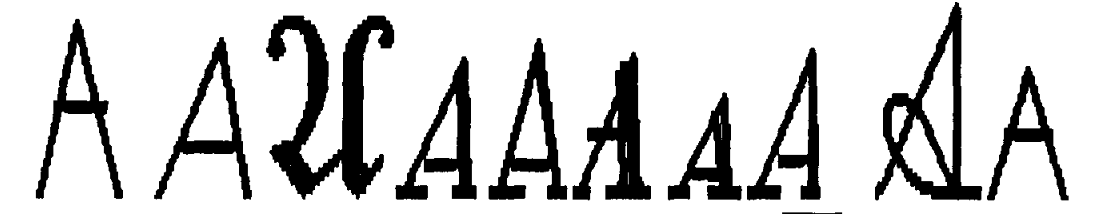

In [3]:
Image("http://andrewpbray.github.io/math-243/assets/figs/letters.png")

### Ransom notes keep falling

One of the most useful applications to come out of classification models has been character (i.e. letter) recognition. In this lab, we build our own character recognition system using boosted trees.

#### The data
Our data set consists of a catalog of 20,000 images of letters. Initially, the images were 45 x 45 pixels, each of which was characterized as either "on" or "off" (black or white). In order to extract more meaningful predictors from the data, resesearchers [^1] went through and performed *feature extraction*, collapsing those 20255 dimensions into 16, each of which is a summary statistic calculated on the image. They are as follows:

1. The horizontal position, counting pixels from the left edge of the image, of the center of the smallest rectangular box that can be drawn with all "on" pixels inside the box.
2. The vertical position, counting pixels from the bottom, of the above box.
3. The width, in pixels, of the box.
4. The height, in pixels, of the box.
5. The total number of "on" pixels in the character image.
6. The mean horizontal position of all "on" pixels relative to the center of the box and divided by the width of the box. This feature has a negative value if the image is "left- heavy" as would be the case for the letter L.
7. The mean vertical position of all "on" pixels relative to the center of the box and divided by the height of the box.
8. The mean squared value of the horizontal pixel distances as measured in 6 above. This attribute will have a higher value for images whose pixels are more widely separated in the horizontal direction as would be the case for the letters W or M.
9. The mean squared value of the vertical pixel distances as measured in 7 above. 
10. The mean product of the horizontal and vertical distances for each "on" pixel as measured in 6 and 7 above. This attribute has a positive value for diagonal lines that run from bottom left to top right and a negative value for diagonal lines from top left to bottom right.
11. The mean value of the squared horizontal distance times the vertical distance for each "on" pixel. This measures the correlation of the horizontal variance with the vertical position.
12. The mean value of the squared vertical distance times the horizontal distance for each "on" pixel. This measures the correlation of the vertical variance with the horizontal position.
13. The mean number of edges (an "on" pixel immediately to the right of either an "off" pixel or the image boundary) encountered when making systematic scans from left to right at all vertical positions within the box. This measure distinguishes between letters like "W" or "M" and letters like 'T' or "L."
14. The sum of the vertical positions of edges encountered as measured in 13 above. This feature will give a higher value if there are more edges at the top of the box, as in the letter "Y."
15. The mean number of edges (an "on" pixel immediately above either an "off" pixel or the image boundary) encountered when making systematic scans of the image from bottom to top over all horizontal positions within the box.
16. The sum of horizontal positions of edges encountered as measured in 15 above.

In addition, each row/image was labeled with the letter that it corresponds to.

You will want to build your model on a training data set and evaluate its performance on a separate test data set. Please use the following indices to subset out the training data set, leaving the remaining as test.

#### Building a boosted tree

#### Contruct a boosted tree to predict the class of the training images (the letters) based on its 16 features. This can be done with the `gbm()` (`GradientBoostingClassifier/Regressor` from `sklearn.ensemble` in Python) function in the library of the same name. Look to the end of chapter 8 for an example of the implementation. 

#### Note that we'll be performing a boosted *classification* tree. It's very similar to the boosted regression tree except the method of calculating a residual is adapted to the classification setting. Please use as your model parameters $B = 50$, $\lambda = 0.1$, and $d = 1$. Note that this is computationally intensive, so it may take a minute to run. Which variable is found to be the most important?

In [4]:
# load datasets
letters_train = pd.read_csv("letters_train.csv")
letters_test = pd.read_csv("letters_test.csv")

letters_train_Y = letters_train["letter"]
letters_train_X = letters_train.drop(["letter"], axis=1)

letters_test_Y = letters_test["letter"]
letters_test_X = letters_test.drop(["letter"], axis=1)

In [5]:
# displays list of features ranked by importance
def implist(model,features,ascending=False):
    l = pd.DataFrame()
    l["features"] = features
    l["importance"] = model.feature_importances_
    l.sort_values(by="importance",axis=0,inplace=True,ascending=ascending)
    
    
    return l

# plots features by importance
def impplot(model,features,ascending=False,n=10):
    l = implist(model,features,ascending)
    lsub = l.iloc[0:n-1,].copy()
    lsub.sort_values(by="importance",axis=0,inplace=True,ascending=True)
    ax = lsub.plot(kind="barh",x="features",y="importance")
    ax.set_ylabel("Features")
    ax.set_xlabel("Gini Importance")
    ax.set_title("Top " + str(n) + " Features")
    
b1 = gbm(learning_rate = 0.1, n_estimators = 50, max_depth = 1, criterion = "mse", min_samples_leaf = 10, random_state=5)
b1.fit(letters_train_X,letters_train_Y)
    


GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=1, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=5, subsample=1.0, verbose=0,
              warm_start=False)

In [6]:
implist(b1,letters_train_X.columns)

,features,importance
11,V12,0.136154
12,V13,0.109231
8,V9,0.100000
7,V8,0.098462
14,V15,0.098462
6,V7,0.085385
13,V14,0.085385
9,V10,0.079231
10,V11,0.077692
15,V16,0.056923


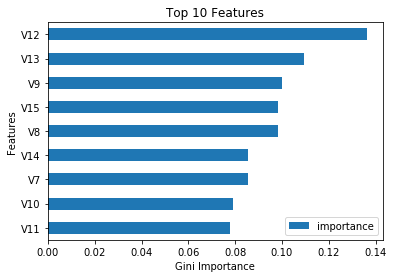

In [7]:
impplot(b1,letters_train_X.columns)

Variable 12 is by far the most important.

<br>


<font color="blue">**R vs Python Note: **The order of importances are similar to the one produced by R but not exact.
It is unclear why they are not exact. The order of the variable importances does not change here in Python when the random_state
variable changes. It does change for R when the seed is different. This may just be explained by seeding.

In addition, R may be measuring variable importance differently than Python (could be Gini vs Deviance). </font>

#### a. Build a cross-tabulation of the predicted and actual letters (a 26 X 26 confusion matrix).


In [8]:
# a
b1_pred = b1.predict(letters_test_X) # predicted values
b1_conf_mat = pd.crosstab(b1_pred,letters_test_Y) # cross tabulation


#### b. What is your misclassification rate? (the function `trace()` might be helpful)


In [9]:
# b
(b1_conf_mat.values.sum() - b1_conf_mat.values.trace())/b1_conf_mat.values.sum() # substract the trace from total to get missclass rate

0.32019999999999998

#### c. What letter was most difficult to predict?

In [10]:
# c
d = {'predicted':b1_pred,'actual':letters_test_Y}
diff = pd.DataFrame(data=d)
diff["missclass"] = np.where(diff["actual"] == diff["predicted"],0,1)

diff_group = diff.groupby("actual")
diff_group.mean().sort_values(by="missclass",ascending=False)


,missclass
actual,
E,0.674757
H,0.582474
G,0.432990
Q,0.397590
K,0.396648
F,0.390863
S,0.385000
D,0.344828
P,0.340000


Letter E

#### d. Are there any letter pairs that are particularly difficult to distinguish?

In [11]:
# takes a missclassification pairs matrix and computes a rate for each pair
def pair_missclass(conf_mat):
    pair_miss = pd.DataFrame()
    
    for i in range(1,len(conf_mat)):
        for j in range(0,i):
            num = conf_mat.iloc[i,j] + conf_mat.iloc[j,i]
            denom = sum(conf_mat.iloc[:,i]) + sum(conf_mat.iloc[:,j])
            
            mc_rate = num/denom
            
            d = {"Pair":pd.Series([conf_mat.index[i] + ", " + conf_mat.columns[j]]), "Missclass Rate":[mc_rate]}
            a = pd.DataFrame(d)
            
            pair_miss = pair_miss.append(a)
    
    pair_miss = pair_miss[["Pair","Missclass Rate"]]
    pair_miss.sort_values(by="Missclass Rate", ascending=False,inplace=True)
    
    return pair_miss
    
pair_miss = pair_missclass(b1_conf_mat)
pair_miss


,Pair,Missclass Rate
0,"D, B",0.103359
0,"Q, G",0.094444
0,"E, C",0.086735
0,"P, F",0.080605
0,"X, E",0.079082
0,"R, B",0.074550
0,"O, H",0.070681
0,"K, C",0.068493
0,"Z, E",0.065274
0,"Q, O",0.062147


From `pair_miss` it appears that the pair of D and B had to highest total missclassification rate at 12%. 
This seems reasonable as the two letters look similar. E actually appears quite often in the highest missclassified 
pairs list, which makes sense considering our answer to part c.**

#### Slow the learning

#### Build a second boosted tree model that uses even *slower* learners, that is, decrease $\lambda$ and increase $B$ somewhat to compensate (the slower the learner, the more of them we need). Pick the parameters of your choosing for this, but be wary of trying to fit a model with too high a $B$. You don't want to wait an hour for your model to fit.



#### a. How does the misclassification rate compare to the rate from you original model?


In [12]:
b2 = gbm(learning_rate = 0.01, n_estimators = 100, max_depth = 1, criterion = "mse", min_samples_leaf = 10, random_state=5)
b2.fit(letters_train_X,letters_train_Y)

b2_pred = b2.predict(letters_test_X)

b2_conf_mat = pd.crosstab(b2_pred,letters_test_Y)

(b2_conf_mat.values.sum() - b2_conf_mat.values.trace())/b2_conf_mat.values.sum()

0.52139999999999997

The new missclassification rate is .521 which is actually significantly worse than the first boosted model.

#### b. Are there any letter pairs that became particularly easier/more difficult to distinguish?

In [13]:
pair_miss2 = pair_missclass(b2_conf_mat)
pair_miss2

,Pair,Missclass Rate
0,"Y, V",0.210227
0,"V, U",0.176316
0,"L, A",0.168342
0,"F, D",0.150000
0,"Z, X",0.137741
0,"D, B",0.134367
0,"K, C",0.123288
0,"Q, O",0.112994
0,"T, P",0.107317
0,"E, C",0.107143


Y and V are now the most difficult to distinguish pair. This pair did not appear the top 10 most difficult pairs in
 the previous model. D and B the previous most difficult to distinguish pair is now the 6th most difficult, but is still 
 more difficult in absolute (13% vs 10% total missclassification).

In [14]:
b3 = gbm(learning_rate = 0.05, n_estimators = 100, max_depth = 1, criterion = "mse", min_samples_leaf = 10, random_state=5)
b3.fit(letters_train_X,letters_train_Y)

b3_pred = b3.predict(letters_test_X)

b3_conf_mat = pd.crosstab(b3_pred,letters_test_Y)

(b3_conf_mat.values.sum() - b3_conf_mat.values.trace())/b3_conf_mat.values.sum()



0.32219999999999999

In [15]:
pair_miss3 = pair_missclass(b3_conf_mat)
pair_miss3

,Pair,Missclass Rate
0,"D, B",0.105943
0,"Q, G",0.097222
0,"E, C",0.081633
0,"X, E",0.079082
0,"P, F",0.078086
0,"K, C",0.073973
0,"R, B",0.071979
0,"O, H",0.070681
0,"Z, E",0.065274
0,"Q, O",0.064972


#### Communities and Crime
#### Return to the Communities and Crime data set. In the last lab you added bagged trees and random forests to your model portfolio in trying to predict the crime level. Constructed model based on a boosted tree with parameters of your choosing. How does the test MSE compare to your existing models?

In [16]:
# Import data
crime_train = pd.read_csv("crime-train.csv")
crime_test = pd.read_csv("crime-test.csv")

In [17]:
# Subset the data (getting rid of columns that aren't predictors). Col 127 is our response

# train
crime_train = crime_train.replace("?",np.nan)
crime_train_X = crime_train.iloc[:,5:100]
crime_train_Y = crime_train["ViolentCrimesPerPop"]
# test
crime_test = crime_test.replace("?",np.nan)
crime_test_X = crime_test.iloc[:,5:100]
crime_test_Y = crime_test["ViolentCrimesPerPop"]

In [18]:
# fit the model
crime_boost = gbm_reg(learning_rate = 0.1, n_estimators = 50, max_depth = 1, criterion = "mse", min_samples_leaf = 10, 
                      random_state=5)
crime_boost.fit(crime_train_X,crime_train_Y)

# importance list
implist(crime_boost,crime_train_X.columns)


,features,importance
43,PctKids2Par,0.12
2,racePctWhite,0.12
40,TotalPctDiv,0.10
67,PctPersDenseHous,0.10
49,PctIlleg,0.08
89,NumStreet,0.06
48,NumIlleg,0.06
1,racepctblack,0.06
37,MalePctDivorce,0.06
70,HousVacant,0.04


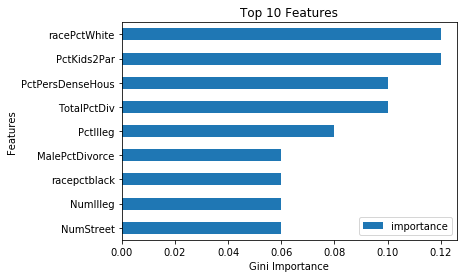

In [19]:
# importance plot
impplot(crime_boost,crime_train_X.columns)

In [20]:
# test MSE
crime_pred = crime_boost.predict(crime_test_X)
np.mean((crime_pred-crime_test_Y)**2)

0.017918287096143227

The variables that were found to be important were very similar to the ones found by the bagging and random forest models
 (family related variables and race).

The previous test MSEs of the bagged model (0.0170) and random forest (0.0171) were very similar to this boosted 
model test MSE 0.0179